Submissions are evaluated using Accuracy Score.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c playground-series-s4e11
!unzip /content/playground-series-s4e11.zip
!rm /content/playground-series-s4e11.zip

Mounted at /content/drive
 88% 4.00M/4.55M [00:00<00:00, 41.9MB/s]
100% 4.55M/4.55M [00:00<00:00, 39.9MB/s]
Archive:  /content/playground-series-s4e11.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
!pip install autogluon.tabular[all]
!pip install dask[dataframe]
!pip install "cleanlab[all]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.8/234.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 49.7 M

## Import Packages

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, GammaRegressor, Ridge
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, KFold
import matplotlib.pyplot as plt
import xgboost as xgb
import re

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from keras_tuner import HyperModel
# from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import layers, models

from autogluon.tabular import TabularDataset, TabularPredictor

import seaborn as sns

from cleanlab.filter import find_label_issues
from cleanlab.classification import CleanLearning

## Load Data

In [ ]:
train = pd.read_csv('/content/train.csv', index_col = 0)
test = pd.read_csv('/content/test.csv', index_col = 0)
sub = pd.read_csv('/content/sample_submission.csv')

In [ ]:
target = [ 'Depression']
cat_cols = ['Gender', 'City', 'Working Professional or Student',
        'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree',
        'Have you ever had suicidal thoughts ?',
        'Family History of Mental Illness']
numeric_cols = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
        'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours',
        'Financial Stress']

### Feature Engineer

In [ ]:
def extract_hours(time_str):
    numbers = list(map(float, re.findall(r'\d+', time_str)))
    if not numbers:
        return None  # Return None if no numbers found

    if "to" in time_str or "-" in time_str:
        # If the string indicates a range, take the average
        return sum(numbers) / len(numbers)
    elif "less" in time_str.lower():
        # If "Less than" appears, subtract 0.5 from the number
        return numbers[0] - 0.5
    elif "more" in time_str.lower():
        # If "More than" appears, add 0.5 to the number
        return numbers[0] + 0.5
    else:
        # Single number cases
        num = numbers[0]
        if num > 24:
            return num / 7  # Divide by 7 if the number is greater than 24
        return num

def process_data(df, verbose=0):
    temp_cat_list = ['Name',    'Gender', 'City', 'Working Professional or Student', 'Profession',  'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
    # Deal with data issues in categorical variables:
    categories_over_20 = {}
    # Iterate over each categorical feature in the list
    for feature in temp_cat_list:
        if feature in train.columns:
            # Find categories with a count greater than 20
            counts = train[feature].value_counts()
            common_categories = counts[counts > 20].index.tolist()
            if common_categories:
                categories_over_20[feature] = common_categories
    df['data_issues'] = [0]*len(df)
    for col1 in temp_cat_list:
        unique_col1 = np.unique([str(x) for x in df[col1].values]).tolist()
        removal = np.unique([uc for uc in unique_col1 for col2 in temp_cat_list if uc in categories_over_20[col2] and not(uc in categories_over_20[col1]) and col1!=col2]).tolist()
        df['data_issues'] = df['data_issues'] + [1 if val in removal else 0 for val in df[col1].values]
        if verbose>0: print(f'We remove from {col1} the following: {removal} (and set it to np.nan)')
        if len(removal)>0:
            df[col1] = df[col1].replace(removal, np.nan)

    # Deal with study/work satisfaction/pressure:
    df['Satisfaction'] = df['Study Satisfaction'].fillna(df['Job Satisfaction'])
    df['Pressure'] = df['Academic Pressure'].fillna(df['Work Pressure'])

    df['Sleep Duration'] = [extract_hours(str(string)) for string in df['Sleep Duration'].values]

    return df

print("Process train")
train = process_data(train)
print("\nProcess test")
test = process_data(test)


Process train

Process test


In [ ]:
people_names = [
    'Mihir', 'Nandini', 'Saanvi', 'Mahi', 'Vidya',
    'Pratyush', 'Harsha', 'Bhavna', 'Atharv', 'Nalini',
    'Keshav', 'Ayush', 'Vaishnavi', 'Chhavi', 'Parth',
    'Vidhi', 'Tushar', 'Rashi', 'Armaan', 'Kagan',
    'Kashish', 'Dhruv', 'Aaradhya', 'Pooja', 'Khushi',
    'Jhanvi', 'Kibara', 'Harsh', 'Reyansh', 'Aditya',
    'Aishwarya', 'Krishna', 'Mira', 'Ishkarsh', 'Raghavendra',
    'Anvi', 'Krinda', 'Ayansh', 'Shrey', 'Ivaan',
    'Vaanya', 'Gaurav'
]

corrected_cities = {
    'Patna': 'Patna',
    'Vasai-Virar': 'Vasai-Virar',
    'Kolkata': 'Kolkata',
    'City': 'Unknown',
    'MCA': 'Unknown',
    'M.Com': 'Unknown',
    'M.Tech': 'Unknown',
    'Researcher': 'Unknown',
    'MSc': 'Unknown',
    'ME': 'Unknown',
    'Ishanabad': 'Ishwar Nagar',  # Likely refers to a neighborhood, not widely recognized as a city
    'Ithal': 'Unknown',  # Not widely recognized
    'Nalyan': 'Navi Mumbai',  # Possible close reference to a known area
    'Galesabad': 'Galsi',  # Possible close reference to a known area
    'Itheg': 'Unknown',  # Not a valid city name
    'Khaziabad': 'Ghaziabad',  # Correction for Ghaziabad
    'Morena': 'Morena',
    'Less Delhi': 'Delhi',  # A misleading representation of Delhi
    'Malyansh': 'Unknown',  # Not a valid city name
    'Plata': 'Unknown',  # Not a valid city name
    '3.0': 'Unknown',  # Not a valid city name
    'Less than 5 Kalyan': 'Kalyan',  # Misleading representation of Kalyan
    'Tolkata': 'Kolkata',  # Spelling correction for Kolkata
    'Unirar': 'Unknown',
     'Molkata':'Kolkata',
    'No':'Unknown',
    'Moreadhyay':'Moradabad',
    'Kashk':'kashi',
}

def clean_city(city):
    if city in people_names:
        return 'Unknown'
    elif city in corrected_cities.keys():
        return corrected_cities[city]
    else:
        return city

train['City'] = train['City'].apply(clean_city)
test['City'] = test['City'].apply(clean_city)

deg_cnt = train['Degree'].value_counts()
def clean_degree(value):
    count = deg_cnt.get(value, 0)
    return value if count >= 100 else 'Unknown'

train['Degree'] = train['Degree'].apply(clean_degree)
test['Degree'] = test['Degree'].apply(clean_degree)

diet_cnt = train['Dietary Habits'].value_counts()

def clean_diet(value):
    count = diet_cnt.get(value, 0)
    return value if count >= 100 else 'Unknown'

train['Dietary Habits'] = train['Dietary Habits'].apply(clean_diet)
test['Dietary Habits'] = test['Dietary Habits'].apply(clean_diet)

In [ ]:
age_bins = [18, 25, 35, 45, 55, 60]
age_labels = ['Emerging Adulthood (18-25)', 'Early Adulthood (26-35)', 'Midlife Transition (36-45)', 'Middle Adulthood (46-55)', 'Late Middle Age (56-60)']
train['age_group'] = pd.cut(train['Age'], bins=age_bins, labels=age_labels, right=True)
test['age_group'] = pd.cut(test['Age'], bins=age_bins, labels=age_labels, right=True)

In [ ]:
feature_cols = [ 'Gender', 'Age', 'City', 'Working Professional or Student',
       'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'age_group']

In [ ]:
train[cat_cols] = train[cat_cols].fillna('missing')
test[cat_cols] = test[cat_cols].fillna('missing')

In [ ]:
# label encode the data
# Initialize target column and categorical columns
target_column = 'Depression'

# Create a copy to avoid data leakage during training
train_encoded = train.copy()

# KFold for robust encoding (optional)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for col in cat_cols:
    # Initialize a new column to hold the target-encoded values
    train_encoded[f'{col}_target_enc'] = 0

    # Loop over each fold
    for train_idx, val_idx in kf.split(train):
        train_fold, val_fold = train.iloc[train_idx], train.iloc[val_idx]

        # Compute the target mean for each category
        target_means = train_fold.groupby(col)[target_column].mean()

        # Map the target means to the validation fold
        train_encoded.loc[val_idx, f'{col}_target_enc'] = val_fold[col].map(target_means)

    # Fill missing values after mapping (if a category wasn't seen in training)
    overall_mean = train[target_column].mean()
    train_encoded[f'{col}_target_enc'].fillna(overall_mean, inplace=True)

# Drop original categorical columns if needed
# train_encoded.drop(columns=cat_cols, inplace=True)

# Initialize a copy of the test dataset
test_encoded = test.copy()

# Calculate the overall mean of the target column
overall_mean = train[target_column].mean()

for col in cat_cols:
    # Compute the target mean for each category in the train dataset
    target_means = train.groupby(col)[target_column].mean()

    # Map the target means to the test dataset
    test_encoded[f'{col}_target_enc'] = test[col].map(target_means)

    # Fill missing values for unseen categories with the overall mean
    test_encoded[f'{col}_target_enc'].fillna(overall_mean, inplace=True)

# Drop original categorical columns from the test dataset if needed
# test_encoded.drop(columns=cat_cols, inplace=True)


## EDA

In [ ]:
train.Depression.value_counts()

,count
Depression,
0,115133
1,25567


In [ ]:
train.Name.nunique()

410

In [ ]:
train.select_dtypes('object').columns, train.select_dtypes('bool').columns, train.select_dtypes('float').columns

(Index(['Name', 'Gender', 'City', 'Working Professional or Student',
        'Profession', 'Dietary Habits', 'Degree',
        'Have you ever had suicidal thoughts ?',
        'Family History of Mental Illness'],
       dtype='object'),
 Index([], dtype='object'),
 Index(['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
        'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
        'Work/Study Hours', 'Financial Stress', 'Satisfaction', 'Pressure'],
       dtype='object'))

In [ ]:
train.isna().sum()

,0
Name,16
Gender,0
Age,0
City,72
Working Professional or Student,0
Profession,36663
Academic Pressure,112803
Work Pressure,27918
CGPA,112802
Study Satisfaction,112803


In [ ]:
train.Age.value_counts()

,count
Age,
56.0,5246
49.0,5099
38.0,4564
53.0,4526
57.0,4395
47.0,4199
46.0,4080
54.0,3928
51.0,3927


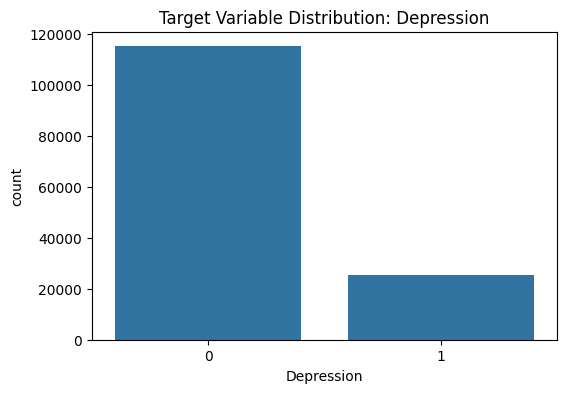

In [ ]:
# Plot target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=train, x='Depression')
plt.title('Target Variable Distribution: Depression')
plt.show()

In [ ]:
test.isna().sum()

,0
Name,0
Gender,0
Age,0
City,0
Working Professional or Student,0
Profession,24632
Academic Pressure,75033
Work Pressure,18778
CGPA,75034
Study Satisfaction,75033


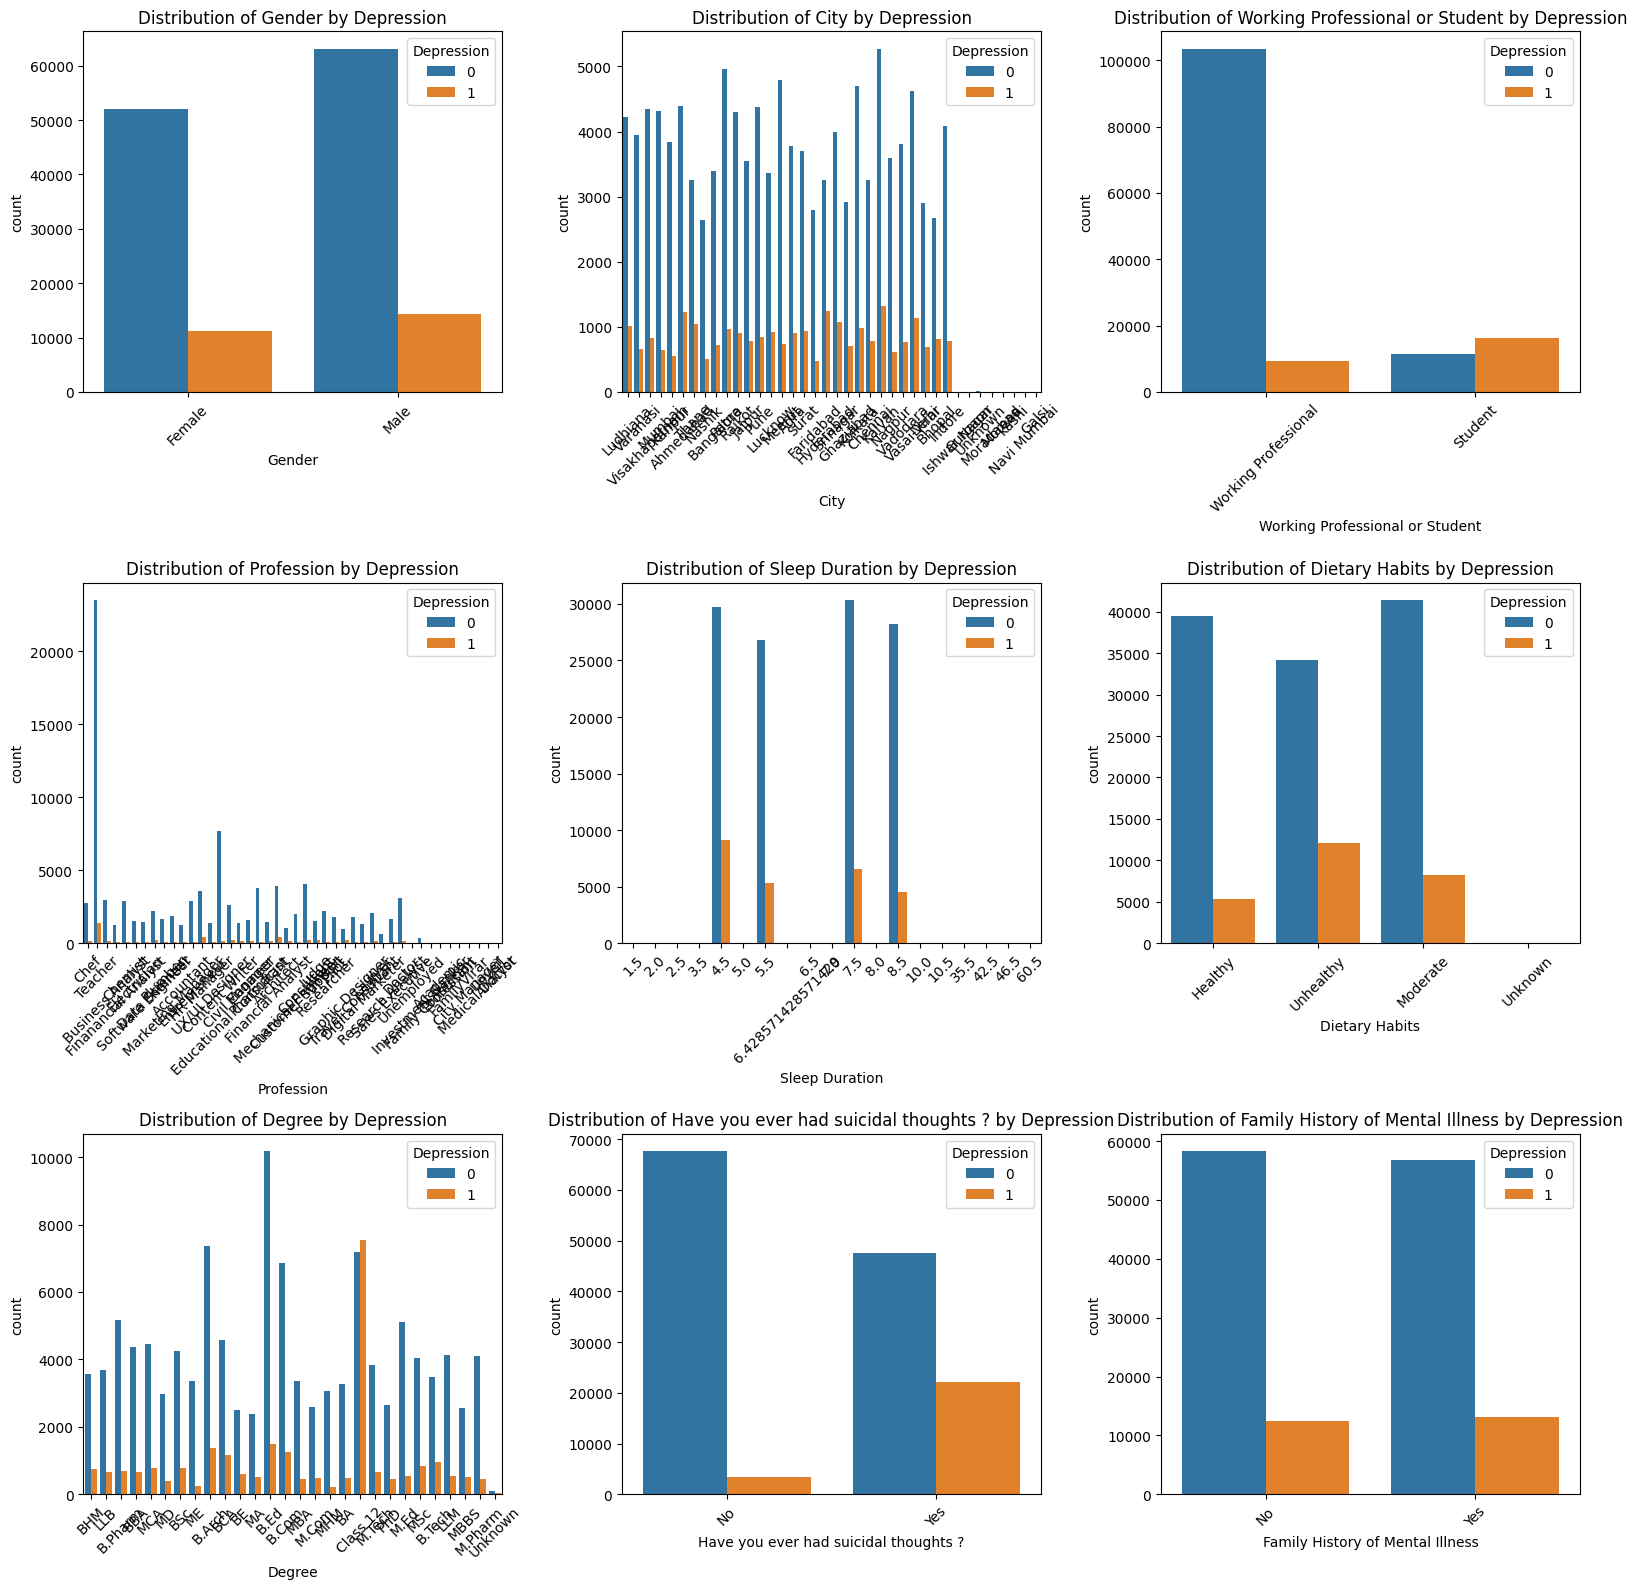

In [ ]:
# Plot distributions of categorical variables
plt.figure(figsize=(16, 16))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=train, x=col, hue='Depression')
    plt.title(f'Distribution of {col} by Depression')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



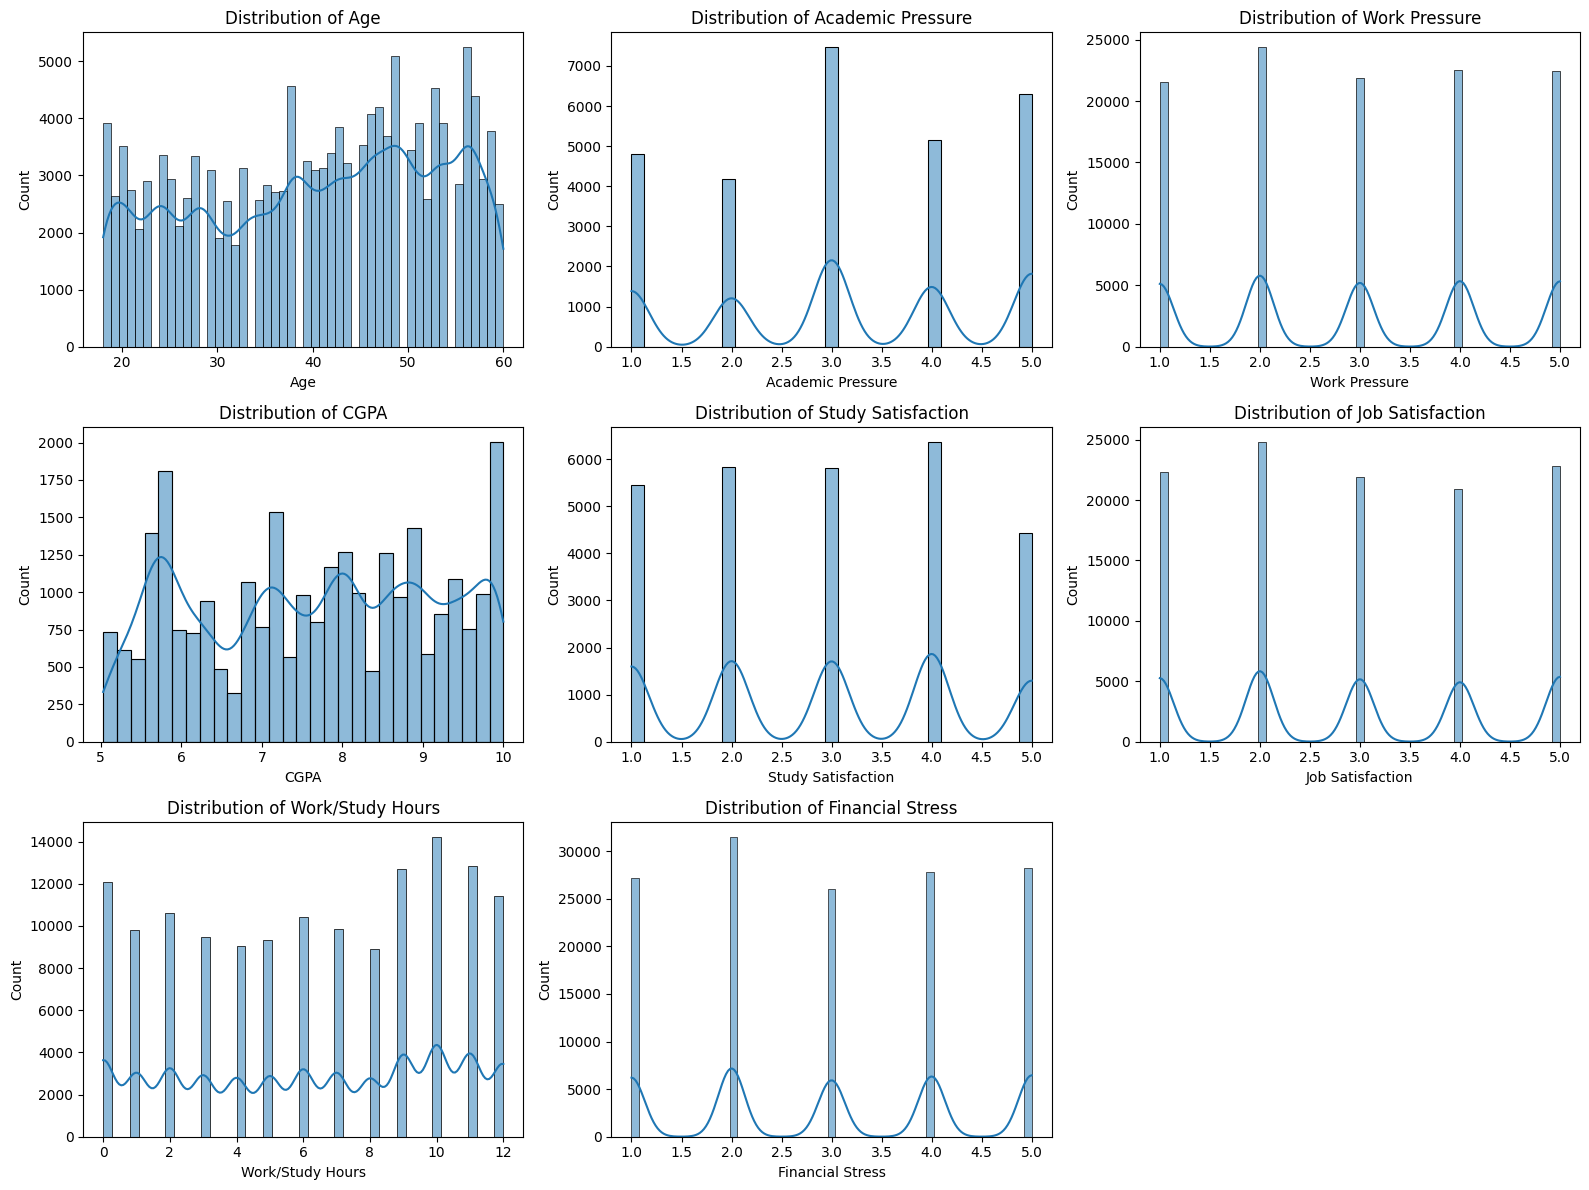

In [ ]:
# Plot histograms of numeric variables
plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=train, x=col, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()



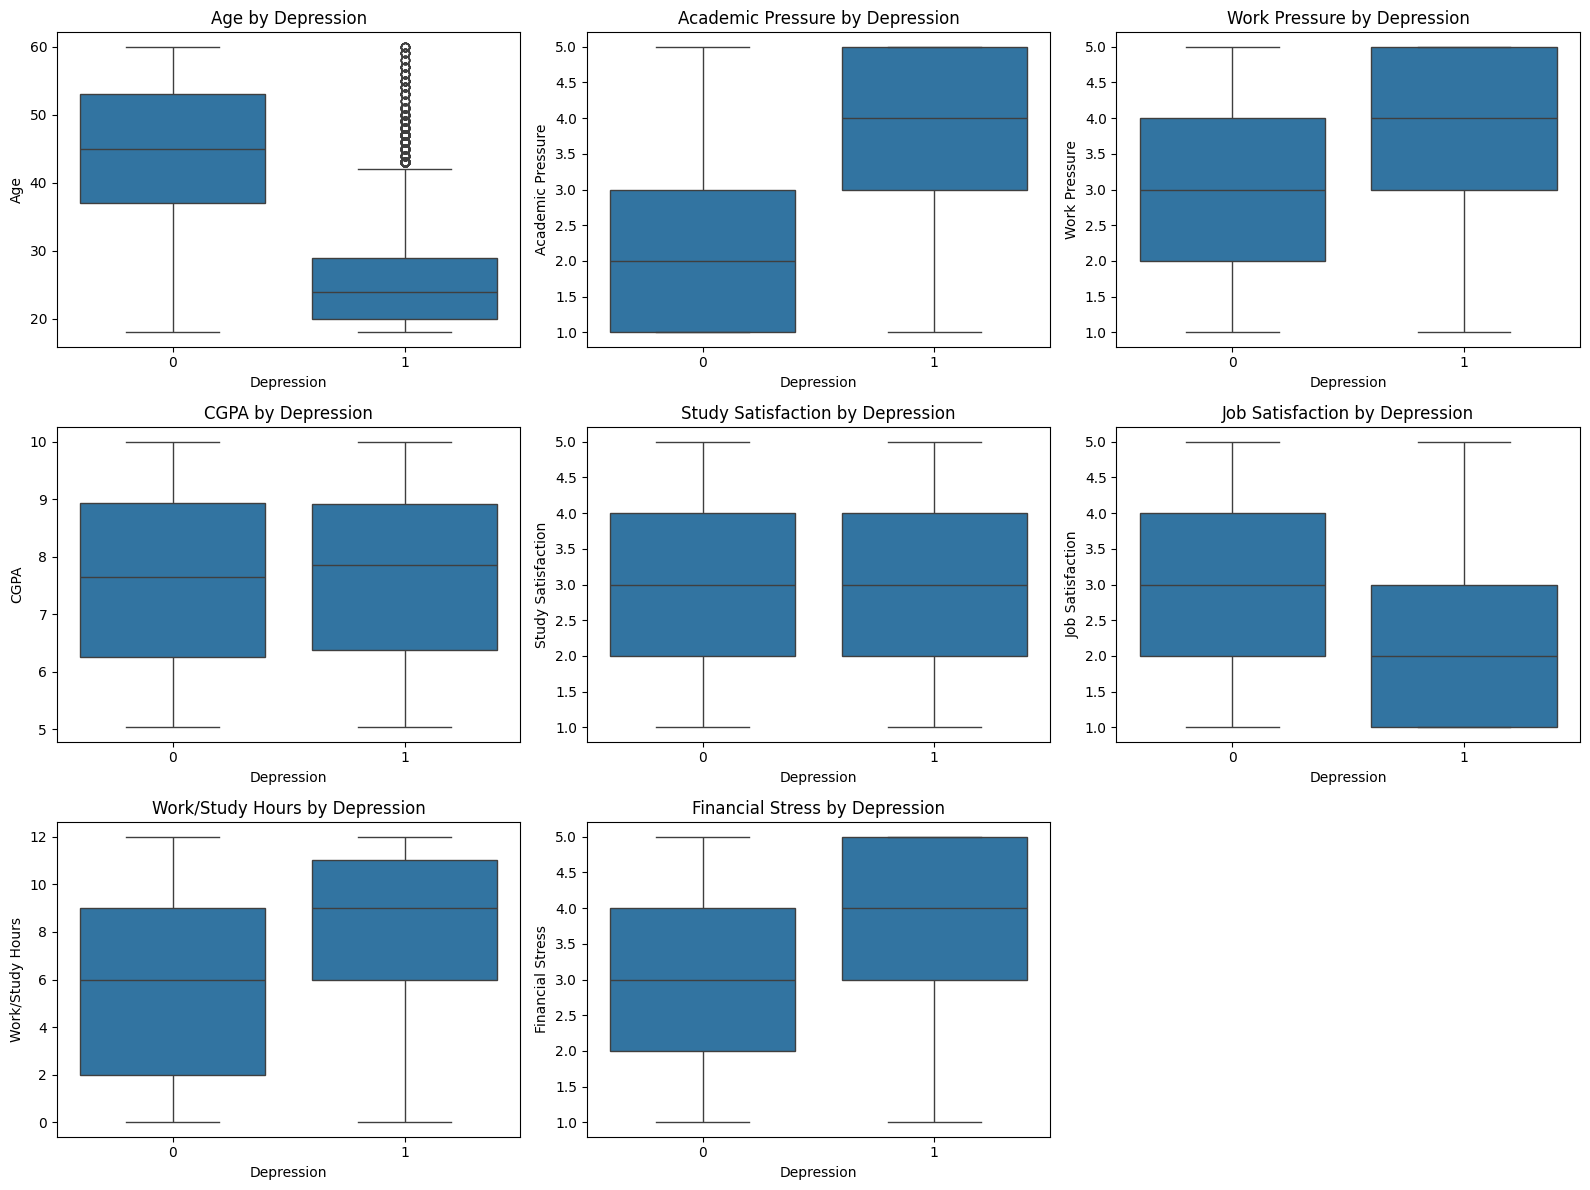

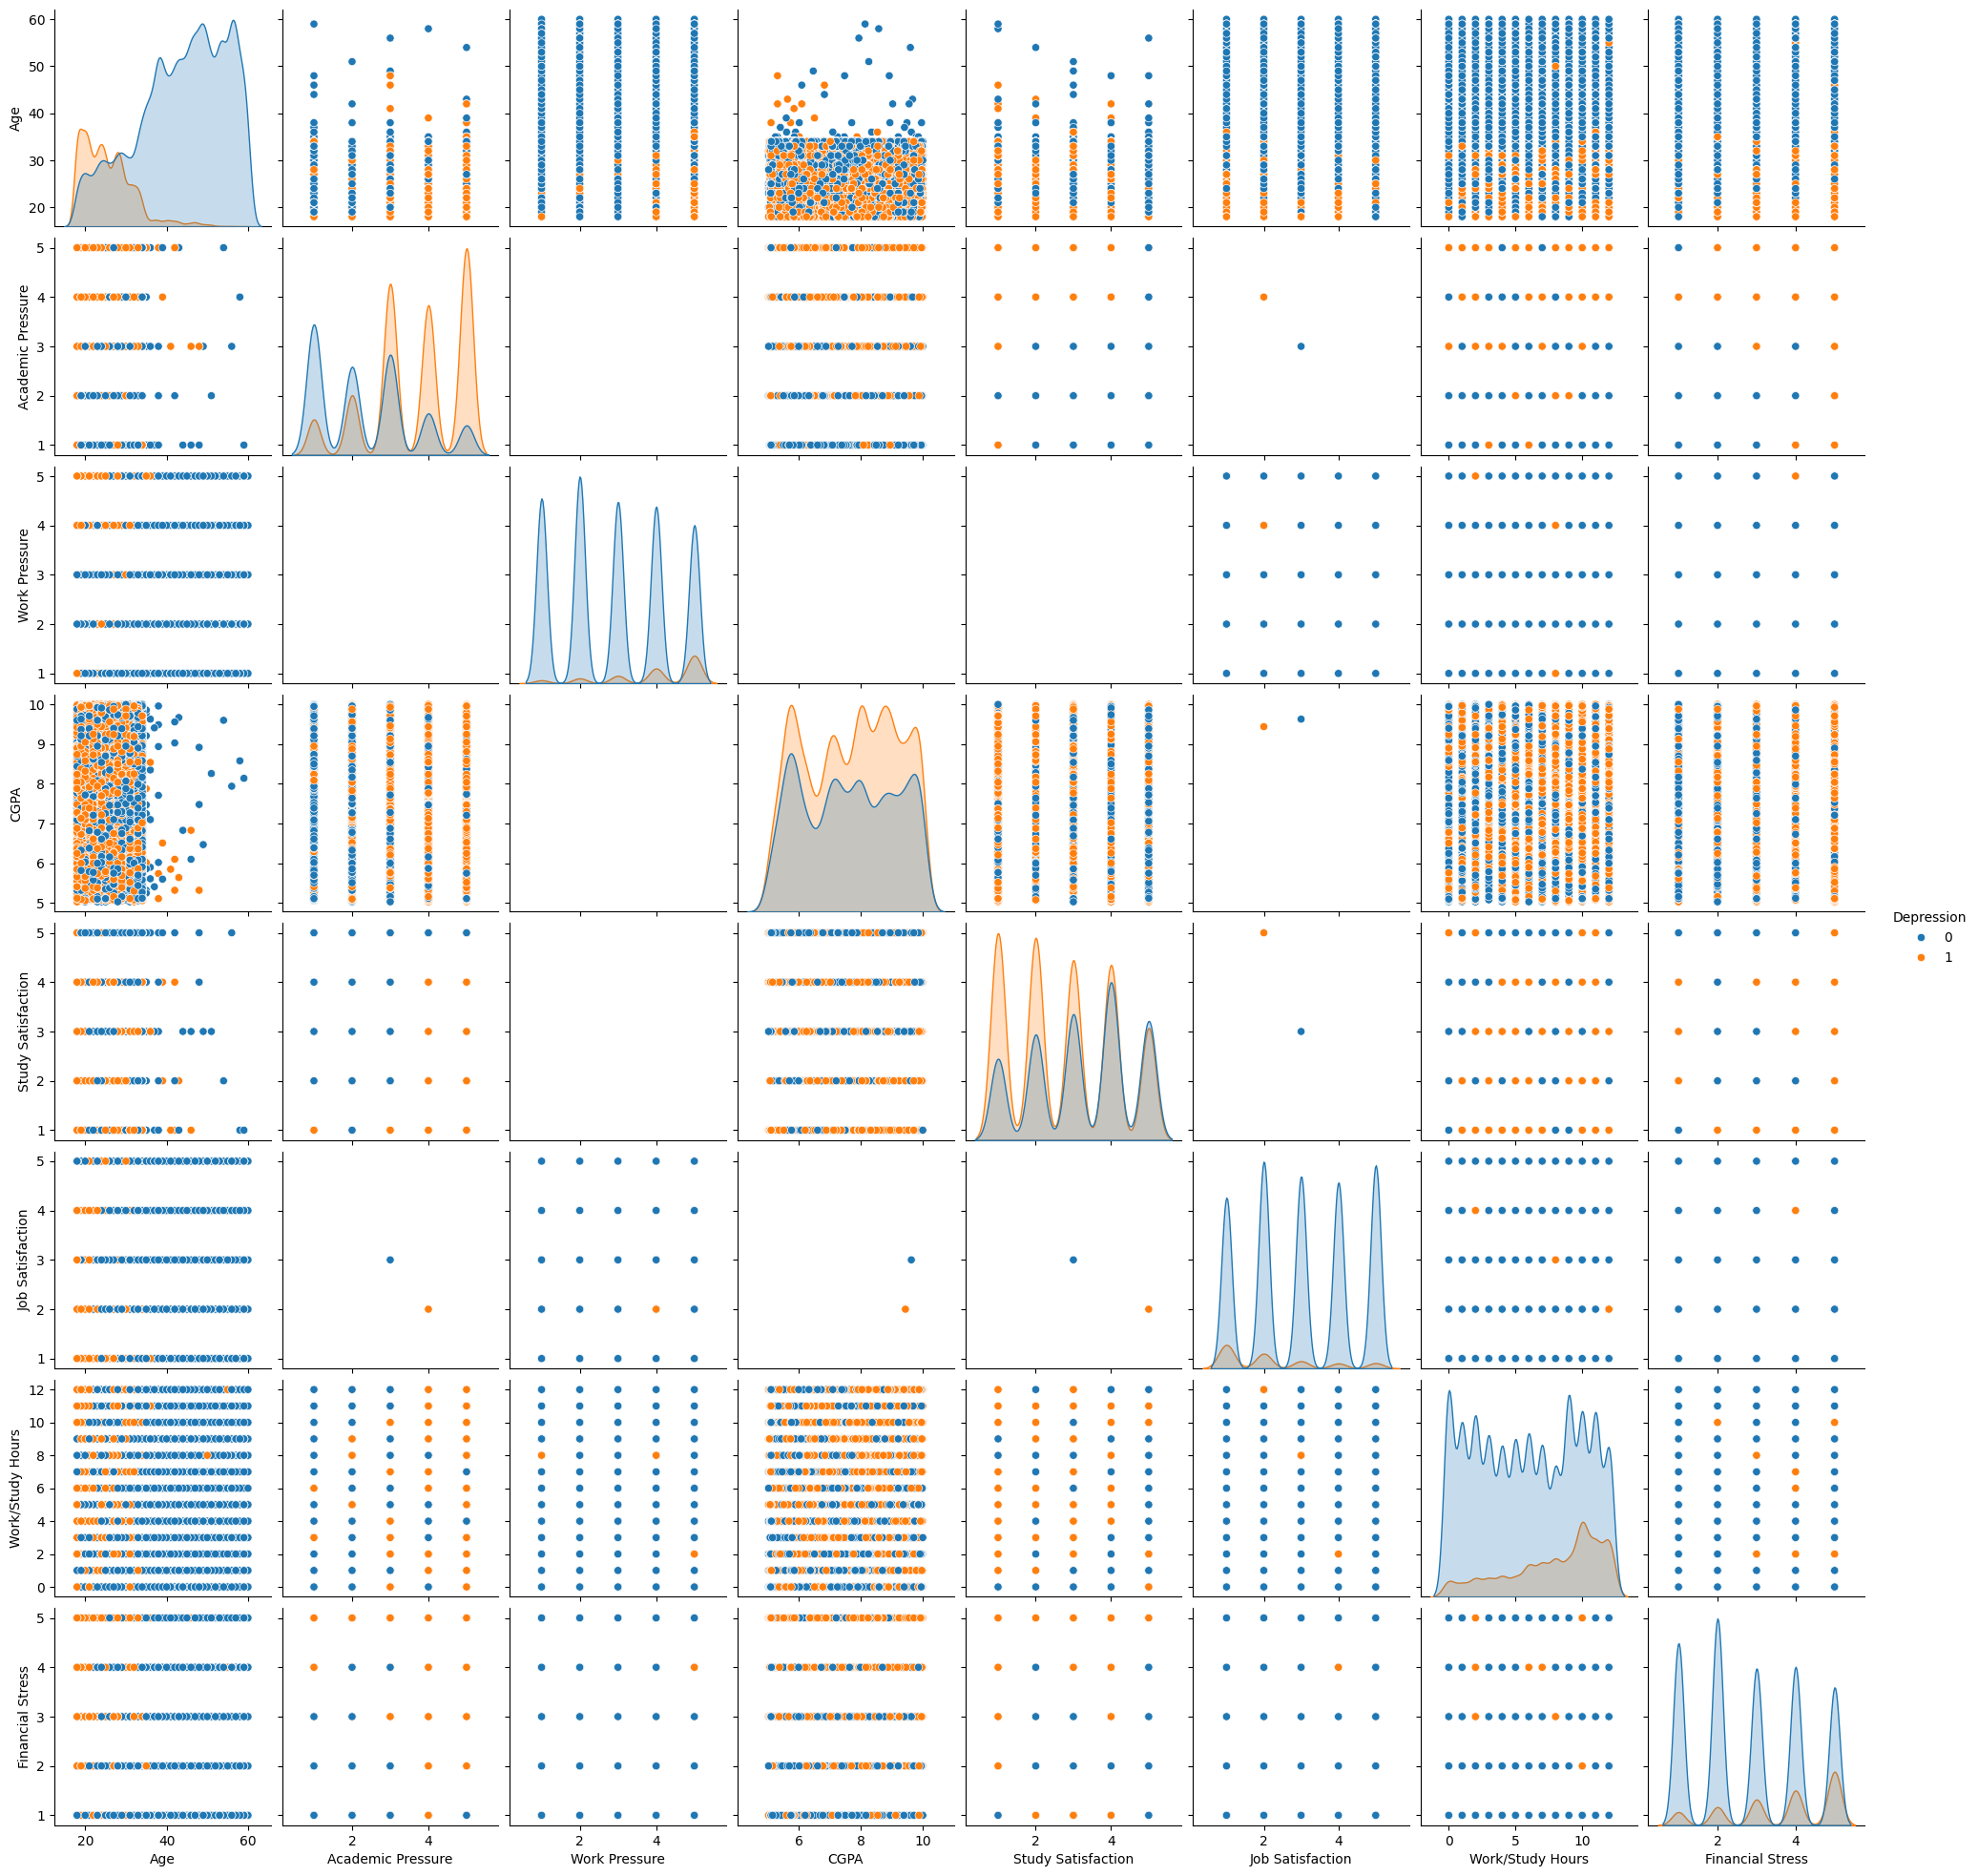

In [ ]:
# Box plots for numeric variables by target variable
plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=train, x='Depression', y=col)
    plt.title(f'{col} by Depression')
plt.tight_layout()
plt.show()



In [ ]:
# Pairplot for numeric features, colored by target variable
sns.pairplot(train, vars=numeric_cols, hue='Depression', diag_kind='kde')
plt.show()

## AutoML Model
1. LightGBMXT_BAG_L1	0.939645	(0.94104) base autogluon
2. WeightedEnsemble_L3	0.975200	(0.94189) base roc score
3. WeightedEnsemble_L2	0.975198 (0.94168) base roc score drop names
4. WeightedEnsemble_L2	0.975197 (0.94179) added age group feature
5. WeightedEnsemble_L3	0.975165 (0.94179) cleaning
6. LightGBMXT_BAG_L2	0.939488 (0.94115) target encoding
7. LightGBMXT_BAG_L1	0.939730 (Score: 0.94147) target encoding plus all columns

In [ ]:
label = 'Depression'
metric = 'accuracy' # ‘roc_auc_ovo_macro’,
time_limit = 600

excluded_model_types = ['KNN']

In [ ]:
train = train_encoded.copy()
test = test_encoded.copy()

In [ ]:
feature_cols = test.columns.tolist()

In [ ]:
predictor = TabularPredictor(label, eval_metric=metric).fit(train[feature_cols + target], auto_stack=True,excluded_model_types=excluded_model_types,
                                                            time_limit=time_limit, presets='best_quality', holdout_frac = 0.2)

No path specified. Models will be saved in: "AutogluonModels/ag-20241126_004658"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       9.32 GB / 12.67 GB (73.5%)
Disk Space Avail:   65.75 GB / 107.72 GB (61.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be 

In [ ]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L1,0.939730,accuracy,3.071319,82.128002,3.071319,82.128002,1,True,1
1,WeightedEnsemble_L3,0.939730,accuracy,3.085660,84.084147,0.014341,1.956145,3,True,7
2,WeightedEnsemble_L2,0.939730,accuracy,3.122282,84.243458,0.050964,2.115456,2,True,4
3,LightGBMXT_BAG_L2,0.939709,accuracy,15.384865,298.562414,1.847450,56.751701,2,True,5
4,LightGBM_BAG_L2,0.939268,accuracy,14.320469,292.097423,0.783054,50.286711,2,True,6
5,LightGBM_BAG_L1,0.939147,accuracy,2.975688,74.355654,2.975688,74.355654,1,True,2
6,RandomForestGini_BAG_L1,0.936546,accuracy,7.490409,85.327057,7.490409,85.327057,1,True,3


In [ ]:
y_pred = predictor.predict_proba(test, as_multiclass = False)
y_pred.index = test.index
y_pred.to_csv('/content/drive/MyDrive/Output/sub.csv')

In [ ]:
# Define your threshold, e.g., 0.5
threshold = 0.5

# Convert probabilities to binary predictions
y_pred2 = (y_pred >= threshold).astype(int)

# Save the output to CSV including the binary predictions
y_pred2.to_csv('/content/drive/MyDrive/Output/sub.csv', index=True)

In [ ]:
!kaggle competitions submit -c playground-series-s4e11 -f /content/drive/MyDrive/Output/sub.csv -m "all feats"

100% 824k/824k [00:00<00:00, 1.29MB/s]
Successfully submitted to Exploring Mental Health Data

## Cleanlab clean data

In [ ]:
labels = train[target]

In [ ]:
pred_probs = predictor.predict_proba(train, as_multiclass = True)

In [ ]:
pred_probs.values.tolist()

[[0.9875709414482117, 0.012429063208401203],
 [0.2919435501098633, 0.7080564498901367],
 [0.37683427333831787, 0.6231657266616821],
 [0.19014739990234375, 0.8098526000976562],
 [0.6352460384368896, 0.36475396156311035],
 [0.9875709414482117, 0.012429063208401203],
 [0.984875500202179, 0.015124507248401642],
 [0.9862322211265564, 0.013767766766250134],
 [0.9565146565437317, 0.04348534345626831],
 [0.939909815788269, 0.06009016931056976],
 [0.9875709414482117, 0.012429063208401203],
 [0.9875709414482117, 0.012429063208401203],
 [0.9855952262878418, 0.014404788613319397],
 [0.9207955002784729, 0.0792044922709465],
 [0.9464865922927856, 0.05351342633366585],
 [0.47018659114837646, 0.5298134088516235],
 [0.9875709414482117, 0.012429063208401203],
 [0.9875709414482117, 0.012429063208401203],
 [0.9875089526176453, 0.012491037137806416],
 [0.9869366884231567, 0.013063288293778896],
 [0.9862508177757263, 0.013749197125434875],
 [0.914682149887085, 0.08531783521175385],
 [0.9874821305274963, 0.0

In [ ]:
ranked_label_issues = find_label_issues(
    labels=labels, pred_probs=pred_probs.values.tolist(), return_indices_ranked_by="self_confidence"
)

TypeError: unhashable type: 'numpy.ndarray'